In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import fcluster, set_link_color_palette
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture as GM
import dc_stat_think as dcst
import dabest
sep = '/'
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='#f2efef'

In [2]:
font = {'fontname':'Calibri'}

### Load data 

In [3]:
recording = r'E:\CIT_WAY\dat_files\cat\csvs'
filename ='neuron_stats.csv'

In [4]:
df = pd.read_csv(os.sep.join([recording, filename]))
df.index.name = 'Cluster_ID'
df = df[pd.notnull(df['SW_troff'])]

In [5]:
df_cit = df[(df['recording']=='Chronic_04_2018-08-05')|(df['recording']=='Chronic_30_2018-07-28')|(df['recording']=='Chronic_40_2018-08-13')|(df['recording']=='Chronic_41_2018-08-09')]
df_cit = df_cit[(df_cit['CV ISI'] != 0)&(df_cit['Firing Rate'] != 0)]

### Scale the data

In [6]:
scale =RobustScaler()
scaled_data = scale.fit_transform(df_cit[['CV ISI', 'Firing Rate']])

### BIC Plot

The star marks the most optimal number of clusters and the most fitting GMM method

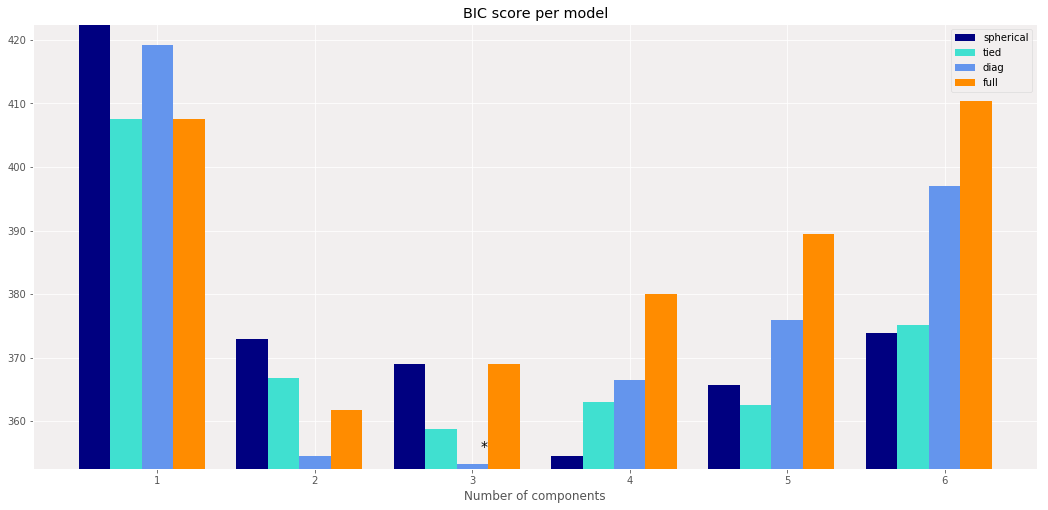

In [10]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GM(n_components=n_components, covariance_type=cv_type).fit(scaled_data)
        bic.append(gmm.bic(scaled_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])

bars = []

plt.figure(figsize=(18,18))
spl = plt.subplot(2, 1, 1)


for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)